In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "svg"  # comment this line to use interactive plots
import plotly.graph_objects as go
import sys
import logging

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

sys.path.append("../components/paddock/")

%load_ext autoreload
%autoreload 2
from telemetry.influx import Influx
from telemetry.analyzer import Analyzer

from IPython.display import Image

pd.set_option("display.max_columns", None)

influx = Influx()
influx.laps_from_file("tracks.csv")
analyzer = Analyzer()

In [2]:
# (game, session, track, car) = "iRacing,1670222575,pocono 2016,Dallara IR18".split(",")
# (game, session, track, car) = "Automobilista 2,1671635969,Cascavel4:Cascavel2,Mercedes-Benz Actros".split(",")
# (game, session, track, car) = "iRacing,1670287161,spielberg gp,Porsche 911 GT3.R".split(",")
(game, session, track, car) = "iRacing,1670238139,spa up,Mercedes W12".split(",")
# (game, session, track, car) = "iRacing,1671643370,charlotte 2018 2019 rallycrosslong,Volkswagen Beetle GRC Lite".split(",")
# (game, session, track, car) = "iRacing,1670846922,nurburgring nordschleife,Porsche 911 GT3 Cup (992)".split(",")
# (game, session, track, car) = "Automobilista 2,1670846922,Nurburgring_2020:Nordschleife_2020_24hr,Porsche Cayman GT4 Clubsport MR".split(",")
# (game, session, track, car) = "Assetto Corsa (64 bit),1670215352,simtraxx_zeran:rally1,porsche_550_1500_rs_spyder_s1".split(",")
# (game, session, track, car) = "iRacing,1670351687,fuji gp,Ferrari 488 GT3 Evo 2020".split(",")
all_laps = influx.telemetry_for(game=game, track=track, car=car)

INFO:root:Processing iRacing spa up : 1670238139 -  1 : 6927 - 102.776634
INFO:root:Processing iRacing spa up : 1670238139 -  2 : 6928 - 103.518967
INFO:root:Processing iRacing spa up : 1670238752 - 15 : 6929 - 103.2187
INFO:root:Processing iRacing spa up : 1670238752 - 16 : 6928 - 103.874069
INFO:root:Processing iRacing spa up : 1670238752 - 18 : 6928 - 104.23233
INFO:root:Processing iRacing spa up : 1670238752 - 17 : 6928 - 104.3793
INFO:root:Processing iRacing spa up : 1670238752 - 19 : 6927 - 104.52977
INFO:root:Processing iRacing spa up : 1670238752 -  9 : 6928 - 104.801735
INFO:root:Processing iRacing spa up : 1670238752 - 20 : 6928 - 104.8196
INFO:root:Processing iRacing spa up : 1670238752 -  3 : 6929 - 104.863068


result  table                           _start  \
0  _result      0 2022-12-05 06:05:44.137256+00:00   
1  _result      0 2022-12-05 06:05:44.137256+00:00   
2  _result      0 2022-12-05 06:05:44.137256+00:00   
3  _result      0 2022-12-05 06:05:44.137256+00:00   
4  _result      0 2022-12-05 06:05:44.137256+00:00   

                             _stop                            _time  \
0 2022-12-05 06:07:26.885396+00:00 2022-12-05 06:05:44.188248+00:00   
1 2022-12-05 06:07:26.885396+00:00 2022-12-05 06:05:44.204125+00:00   
2 2022-12-05 06:07:26.885396+00:00 2022-12-05 06:05:44.245310+00:00   
3 2022-12-05 06:07:26.885396+00:00 2022-12-05 06:05:44.263919+00:00   
4 2022-12-05 06:07:26.885396+00:00 2022-12-05 06:05:44.314962+00:00   

       CarModel CurrentLap GameName   SessionId SessionTypeName TrackCode  \
0  Mercedes W12          1  iRacing  1670238139         Qualify    spa up   
1  Mercedes W12          1  iRacing  1670238139         Qualify    spa up   
2  Mercedes W12          1  iRacing  1670238139         Qualify    spa up   
3  Mercedes W12          1  iRacing  1670238139         Qualify    spa up   
4  Mercedes W12          1  iRacing  1670238139         Qualify    spa up   

  _measurement      host                                              topic  \
0      laps_cc  telegraf  crewchief/Jim/1670238139/iRacing/spa up/Merced...   
1      laps_cc  telegraf  crewchief/Jim/1670238139/iRacing/spa up/Merced...   
2      laps_cc  telegraf  crewchief/Jim/1670238139/iRacing/spa up/Merced...   
3      laps_cc  telegraf  crewchief/Jim/1670238139/iRacing/spa up/Merced...   
4      laps_cc  telegraf  crewchief/Jim/1670238139/iRacing/spa up/Merced...   

  user  Brake    Clutch  CurrentLapTime  DistanceRoundTrack  Gear  Handbrake  \
0  Jim    0.0  0.922072             0.0            2.839830   6.0        0.0   
1  Jim    0.0  0.921332             0.0            5.017566   6.0        0.0   
2  Jim    0.0  0.922318             0.0            7.204051   6.0        0.0   
3  Jim    0.0  0.921825             0.0            9.398693   6.0        0.0   
4  Jim    0.0  0.922318             0.0           11.601985   6.0        0.0   

   Rpms    SpeedMs  SteeringAngle  Throttle            id  
0   0.0  65.220690      -0.010169       1.0  1670238139-1  
1   0.0  65.475400      -0.011137       1.0  1670238139-1  
2   0.0  65.731606      -0.012105       1.0  1670238139-1  
3   0.0  65.980370      -0.014527       1.0  1670238139-1  
4   0.0  66.228584      -0.014527       1.0  1670238139-1

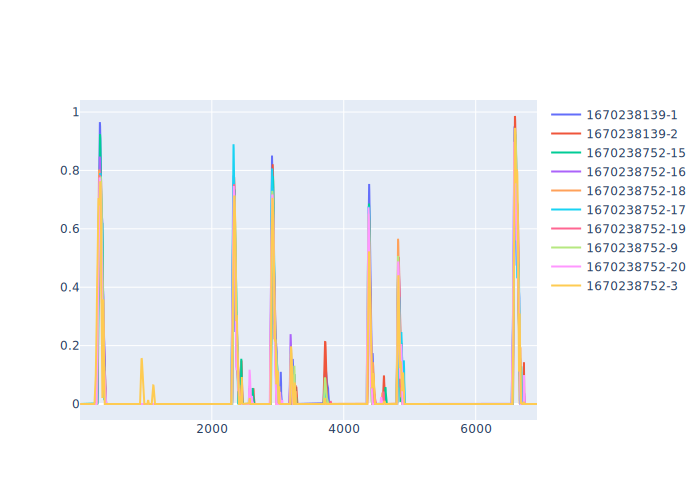

In [3]:
display(all_laps[0].head())
fig = go.Figure()

for df in all_laps:
    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["Brake"],
        marker=dict(size=2),
        name=df["id"].iloc[0],
    )
fig.show()

In [4]:
# remove laps that are too different from the others
laps = analyzer.remove_uncorrelated_laps(all_laps, column="Brake", threshold=0.5)

DEBUG:root:remove lap: 1670238139-1


In [5]:
# get the max distance for each lap and select the max
max_distance = np.max([df["DistanceRoundTrack"].max() for df in laps])

display(f"max distance: {max_distance}")

'max distance: 6929.449'

DistanceRoundTrack  Brake    SpeedMs            id
0               2.339065    0.0  65.362100  1670238139-2
1               4.339075    0.0  65.541513  1670238139-2
2               6.339085    0.0  65.773718  1670238139-2
3               8.339094    0.0  66.000832  1670238139-2
4              10.339104    0.0  66.222839  1670238139-2
...                  ...    ...        ...           ...
3459         6920.372961    0.0  61.109219  1670238139-2
3460         6922.372971    0.0  61.339693  1670238139-2
3461         6924.372980    0.0  61.557472  1670238139-2
3462         6926.372990    0.0  61.656956  1670238139-2
3463         6928.373000    0.0  61.917778  1670238139-2

[3464 rows x 4 columns]

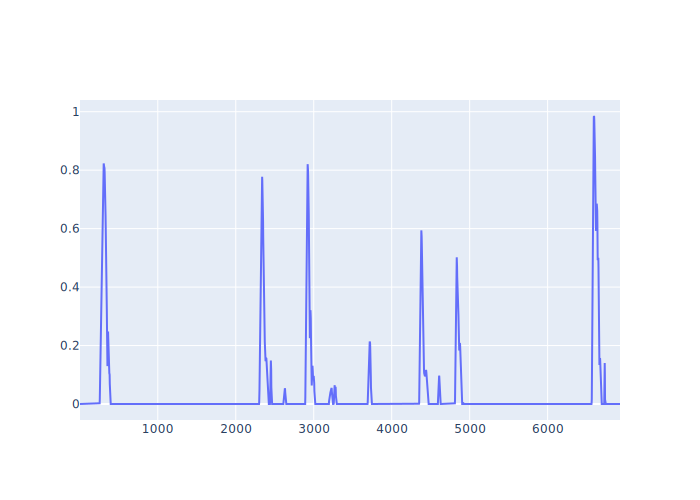

In [6]:
df = laps[0].copy()
df = analyzer.resample(df, freq=2)
display(df)

fig = go.Figure()
fig.add_scatter(
    x=df["DistanceRoundTrack"],
    y=df["Brake"],
    mode="lines",
    marker=dict(size=2),
    name="combined",
)

number of minima 36 for lap 1670238139-2
number of minima 33 for lap 1670238752-15
number of minima 33 for lap 1670238752-16
number of minima 33 for lap 1670238752-18
number of minima 27 for lap 1670238752-17
number of minima 36 for lap 1670238752-19
number of minima 27 for lap 1670238752-9
number of minima 33 for lap 1670238752-20
number of minima 48 for lap 1670238752-3


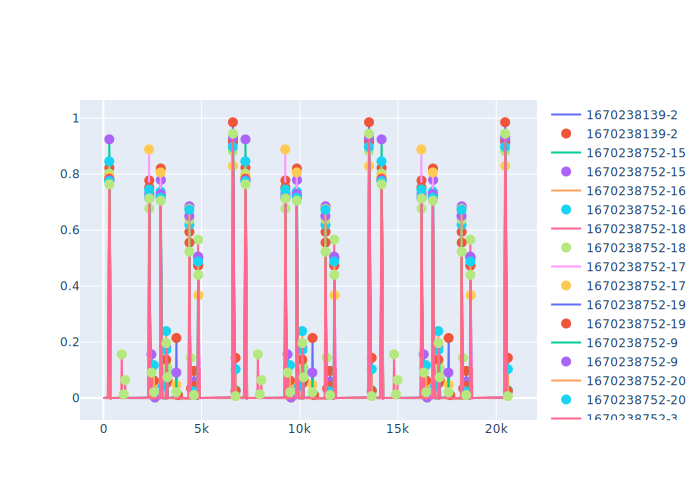

In [7]:
# create one plotly figure
fig = go.Figure()
all_minima = []
for df in laps:
    df = analyzer.drop_decreasing(df)
    df = analyzer.resample(df, freq=1)
    df = analyzer.extend_lap(df)

    # smooth the laps
    window_length = 10  # meters
    df["Brake"] = savgol_filter(df["Brake"], window_length, 2)

    # remove points less than 0
    # df = df[df["Brake"] >= 0]

    fig.add_scatter(
        x=df["DistanceRoundTrack"],
        y=df["Brake"],
        mode="lines",
        marker=dict(size=2),
        name=df["id"].iloc[0],
    )
    extrema = analyzer.local_maxima(df, column="Brake", points=30)
    print(f"number of minima {len(extrema)} for lap {df['id'].iloc[0]}")
    all_minima.append(extrema)

    fig.add_scatter(
        x=extrema["DistanceRoundTrack"],
        y=extrema["Brake"],
        mode="markers",
        marker=dict(size=10),
        name=df["id"].iloc[0],
    )
    # break

fig.show()

In [8]:
fig = go.Figure()
df = laps[0]
df = analyzer.extend_lap(df)

fig.add_scatter(
    x=df["DistanceRoundTrack"], y=df["Brake"], marker=dict(size=2), name="ref"
)

centroids_df, labels = analyzer.cluster(all_minima, field="Brake")

# Plot the laps points with different colors for each cluster the colors are in lables
fig.add_scatter(
    y=df["Brake"],
    x=df["DistanceRoundTrack"],
    mode="markers",
    marker=dict(size=1, color=labels),
)
fig.add_scatter(
    y=df["SpeedMs"] / 50,
    x=df["DistanceRoundTrack"],
    mode="markers",
    marker=dict(size=1, color=labels),
)

# Add the centroids to the plot
fig.add_scatter(
    x=centroids_df["DistanceRoundTrack"],
    y=centroids_df["Brake"],
    mode="markers+text",
    marker=dict(size=10, color="red"),
)

Brake  DistanceRoundTrack
0   0.809521          303.174571
1   0.077729         1027.828595
2   0.633795         2356.950352
3   0.043055         2595.235094
4   0.677811         2928.748691
5   0.126146         3219.329681
6   0.076756         3731.088526
7   0.526454         4391.450892
8   0.040431         4600.361902
9   0.479693         4827.308591
10  0.609561         6643.300250

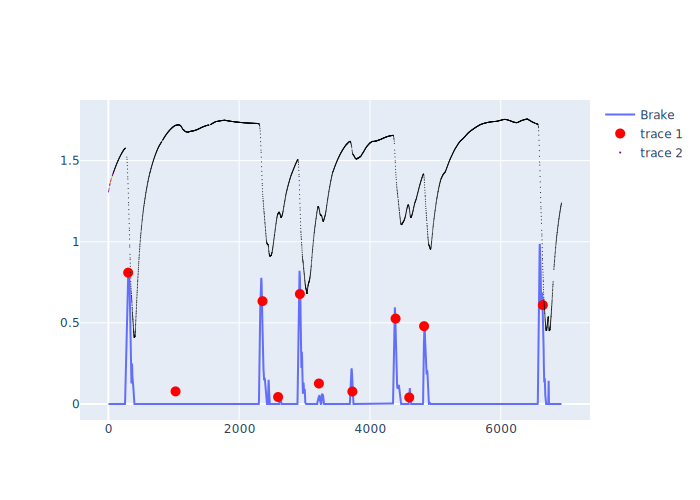

In [9]:
# display(centroids_df)
# sort the centroids by DistanceRoundTrack and reset the index
centroids_df = centroids_df.sort_values(by=["DistanceRoundTrack"])
centroids_df = centroids_df.reset_index(drop=True)
df = centroids_df.copy()

# apply modulo length to DistanceRoundTrack
df["DistanceRoundTrack"] = df["DistanceRoundTrack"].mod(max_distance)

# sort the centroids by DistanceRoundTrack and reset the index
df = df.sort_values(by=["DistanceRoundTrack"])
df = df.reset_index(drop=True)
# display(df)

n_clusters = int(len(df) / 3)
turns, labels = analyzer.cluster([df], field="Brake", n_clusters=n_clusters)
turns = turns.sort_values(by=["DistanceRoundTrack"])
turns = turns.reset_index(drop=True)
display(turns)

fig = go.Figure()
df = laps[0].copy()

fig.add_scatter(
    x=df["DistanceRoundTrack"], y=df["Brake"], marker=dict(size=2), name="Brake"
)

# Add the turns to the plot
fig.add_scatter(
    x=turns["DistanceRoundTrack"],
    y=turns["Brake"],
    mode="markers+text",
    marker=dict(size=10, color="red"),
)

fig.add_scatter(
    y=df["SpeedMs"] / 50,
    x=df["DistanceRoundTrack"],
    mode="markers",
    marker=dict(size=1, color=labels),
)

In [10]:
# for each turn
for i in range(len(turns)):
    # get the distance of the turn
    brake_max = turns["Brake"].iloc[i]
    distance = turns["DistanceRoundTrack"].iloc[i]
    # display(f'brake force {brake_max} at distance {distance}')

    brake_starts = []
    for df in laps:
        # go back from the turn to find where Brake starts
        brake = brake_max
        # find the index in df where DistanceRoundTrack is equal to distance
        index = df[df["DistanceRoundTrack"] > distance].index[0]
        brake_start = distance
        while brake > 0.1:
            index -= 1
            if index < 0:
                index = len(df) - 1
            brake = df["Brake"].iloc[index]
            brake_start = df["DistanceRoundTrack"].iloc[index]
        brake_starts.append(brake_start)
        # print(f"brake start {brake_start} ({brake})")

    # find median gear
    # display(gears)
    brake_start = int(np.median(brake_starts))
    print(
        f"turn {i} brake peak at distance {distance} with force {brake_max} starting at to brake at {brake_start}"
    )

turn 0 brake peak at distance 303.17457089923755 with force 0.8095214415688532 starting at to brake at 263
turn 1 brake peak at distance 1027.8285952011092 with force 0.07772926810651287 starting at to brake at 1027
turn 2 brake peak at distance 2356.950352092433 with force 0.6337953608015185 starting at to brake at 2309
turn 3 brake peak at distance 2595.235093857148 with force 0.043054724860137505 starting at to brake at 2595
turn 4 brake peak at distance 2928.7486913070143 with force 0.6778113767079179 starting at to brake at 2892
turn 5 brake peak at distance 3219.3296808935156 with force 0.12614622610057724 starting at to brake at 3226
turn 6 brake peak at distance 3731.088525744613 with force 0.0767564980358183 starting at to brake at 3731
turn 7 brake peak at distance 4391.450892045639 with force 0.5264535655254798 starting at to brake at 4355
turn 8 brake peak at distance 4600.361901697573 with force 0.04043100194144633 starting at to brake at 4600
turn 9 brake peak at distance